In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier
import optuna

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('emails.csv')
df = df.set_index('Email No.')
df.head()

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
Email No.,,,,,,,,,,,,,,,,,,,,,
Email 1,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Email 2,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
Email 3,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
Email 4,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
Email 5,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5172 entries, Email 1 to Email 5172
Columns: 3001 entries, the to Prediction
dtypes: int64(3001)
memory usage: 118.5+ MB


In [4]:
X = df.drop('Prediction', axis=1)
y = pd.DataFrame(df['Prediction'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [5]:
model = LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_valid)

print(f'accuracy_score: {accuracy_score(y_valid, preds)}')

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073
accuracy_score: 0.9768041237113402


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1111
           1       0.95      0.97      0.96       441

    accuracy                           0.98      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.98      0.98      0.98      1552



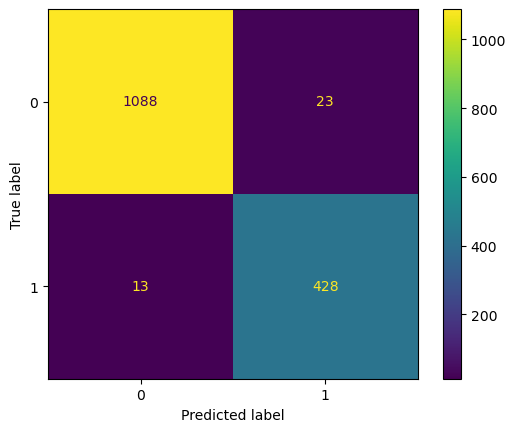

In [6]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()
print(classification_report(y_valid, preds))

# Optuna

In [11]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    booster = trial.suggest_categorical('booster', ['gbtree', 'lglinear', 'dart'])
    clf = LGBMClassifier(n_estimators=n_estimators, booster=booster)
    clf.fit(X_train, y_train)
    return clf.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

model_params_list = ['n_estimators', 'booster']
model_params = dict()
for key, value in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

model = LGBMClassifier(**model_params)
model.fit(X_train, y_train)

[I 2024-10-11 13:13:19,289] A new study created in memory with name: no-name-753903ba-2a31-458f-a26e-b2fd37498a37
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073


[I 2024-10-11 13:13:20,883] Trial 0 finished with value: 0.979381443298969 and parameters: {'n_estimators': 222, 'booster': 'lglinear'}. Best is trial 0 with value: 0.979381443298969.


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073


[I 2024-10-11 13:13:22,529] Trial 1 finished with value: 0.9787371134020618 and parameters: {'n_estimators': 249, 'booster': 'dart'}. Best is trial 0 with value: 0.979381443298969.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073


[I 2024-10-11 13:13:23,609] Trial 2 finished with value: 0.9774484536082474 and parameters: {'n_estimators': 132, 'booster': 'dart'}. Best is trial 0 with value: 0.979381443298969.


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: booster


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Info] Number of positive: 1059, number of negative: 2561
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19779
[LightGBM] [Info] Number of data points in the train set: 3620, number of used features: 2441
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.292541 -> initscore=-0.883073
[LightGBM] [Info] Start training from score -0.883073


LGBMClassifier(booster='lglinear', n_estimators=222)